### SGD_Sampling_Behavior
* Two Sampling Schemes: With Replacement and Without Replacement
* Iris Data 30 Runs, Confidence Level = 95%

### Import Libraries

In [ ]:
# Utilities
import numpy as np
import random

import scipy
from scipy.stats import t

# Data Loading and Processing
import pandas as pd
from sklearn.datasets import load_iris
from sklearn.model_selection import train_test_split
from torch.utils.data import DataLoader,TensorDataset,RandomSampler

# Model training
import torch
import torch.nn as nn

# Data Visualization
import matplotlib.pyplot as plt
import matplotlib_inline.backend_inline
matplotlib_inline.backend_inline.set_matplotlib_formats('svg')

### Load iris data

In [134]:
# Load the dataset
iris_data = load_iris(as_frame=True)

# Store names
feature_names = iris_data.feature_names
label_names = iris_data.target_names

# Create a pd dataframe
iris_df = iris_data.frame

In [131]:
# Take a look of data
iris_df.head()
iris_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 150 entries, 0 to 149
Data columns (total 5 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   sepal length (cm)  150 non-null    float64
 1   sepal width (cm)   150 non-null    float64
 2   petal length (cm)  150 non-null    float64
 3   petal width (cm)   150 non-null    float64
 4   target             150 non-null    int64  
dtypes: float64(4), int64(1)
memory usage: 6.0 KB


In [ ]:
# Convert data from pd.dataframe to pytorch tensors
X = iris_df.drop('target', axis=1)
y = iris_df['target']

data_raw = X.values
labels_raw = y.values

data = torch.tensor(data_raw, dtype=torch.float32)
labels = torch.tensor(labels_raw, dtype=torch.long)

In [149]:
feature_names

['sepal length (cm)',
 'sepal width (cm)',
 'petal length (cm)',
 'petal width (cm)']

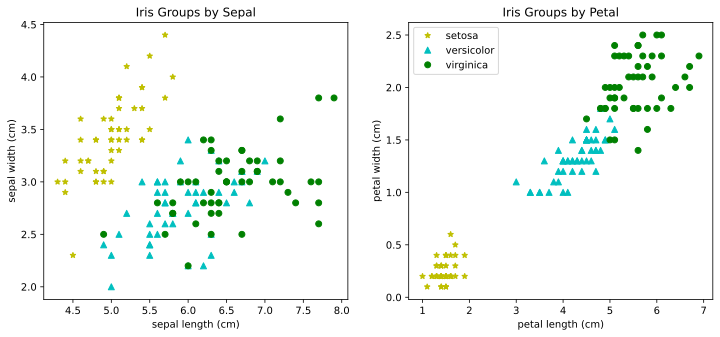

In [153]:
# Plot data
fig,ax = plt.subplots(1,2,figsize=(12,5))

ax[0].plot(data[np.where(labels==0)[0],0],data[np.where(labels==0)[0],1],'y*')
ax[0].plot(data[np.where(labels==1)[0],0],data[np.where(labels==1)[0],1],'c^')
ax[0].plot(data[np.where(labels==2)[0],0],data[np.where(labels==2)[0],1],'go')
ax[0].set_title('Iris Groups by Sepal')
ax[0].set_xlabel(feature_names[0])
ax[0].set_ylabel(feature_names[1])

ax[1].plot(data[np.where(labels==0)[0],2],data[np.where(labels==0)[0],3],'y*')
ax[1].plot(data[np.where(labels==1)[0],2],data[np.where(labels==1)[0],3],'c^')
ax[1].plot(data[np.where(labels==2)[0],2],data[np.where(labels==2)[0],3],'go')
ax[1].set_title('Iris Groups by Petal')
ax[1].set_xlabel(feature_names[2])
ax[1].set_ylabel(feature_names[3])



plt.legend(label_names)
plt.show()

## Global Variables

In [34]:
CONFIDENCE_LEVEL = 0.95
NUM_SAMPLE = 30

In [35]:
# Validate inputs
if not 0 <= CONFIDENCE_LEVEL <= 1:
    # If input not in the range, raise a ValueError 
    raise ValueError(f"Input two-tailed confidence level must be in the range [0, 1], but got {CONFIDENCE_LEVEL}")

In [36]:
# Define sampling scheme
SAMPLING_SCHEMES = {
    'With replacement': True,
    'No replacement': False
}

In [92]:
class MetricsTracker():
    '''
    A class to store and manage training and testing metrics across different 
    sampling schemes and multiple experimental runs.
    '''
    
    
    DEFAULT_METRICS = ['train_acc', 'test_acc', 'train_loss', 'test_loss']

    def __init__(self,schemes=SAMPLING_SCHEMES, metrics_to_track=DEFAULT_METRICS):
        '''
        Initializes the nested dictionary structure using dictionary comprehension.
        '''
        
        self.metrics = {
            scheme_name: {
                metric: [] for metric in metrics_to_track
            } for scheme_name in schemes.keys()
        }

    def add_run_results(self, scheme, results):
        '''
        Adds the averaged final metrics from a single run to the tracker.
        '''
        if scheme not in self.metrics:
            raise ValueError(f"Unknown scheme: {scheme}")
            
        for metric, value in results.items():
            if metric in self.metrics[scheme]:
                # Ensure values are added as floats/items if they come from NumPy/Tensor
                self.metrics[scheme][metric].append(float(value))
            else:
                raise KeyError(f"Unknown metric '{metric}' for scheme '{scheme}'")


    def get_scheme_meteric(self, scheme, metric_name):
        '''
        Retrieves the list of results for a specific metric and scheme.
        '''
        return self.metrics[scheme][metric_name]
    

    def get_mean(self, scheme, metric_name):
        '''
        Return sample mean(average) of a metric, round to 4 decimals
        '''
        data = self.get_scheme_meteric(scheme, metric_name)

        if not data:
            return None
        else:
            return round(np.mean(data).item(),4)
    
    def get_std(self, scheme, metric_name):
        '''
        Return sample standard deviation of a metric, round to 4 decimals
        '''
        data = self.get_scheme_meteric(scheme, metric_name)

        if not data:
            return None
        else:
            return round(np.std(data, ddof=1).item(),4)
        
    
    def compute_confidence_interval (self, scheme, metric_name,confidence_level=CONFIDENCE_LEVEL, num_samples=NUM_SAMPLE):
        '''
        Return the confidence interval (lower_bound, upper_bound) for a single metric
        '''
    
        # Compute significance level and tail
        alpha = 1 - confidence_level
        q = 1 - (alpha/2)

        # Degree of Freedom
        ddof = num_samples - 1

        # T-critical value
        t_score = scipy.stats.t.ppf(q, ddof)

        # Sample mean and sample std
        mean = self.get_mean(scheme, metric_name)
        std = self.get_std(scheme, metric_name)

        # Compute confidence intervals
        lower_bound = mean - t_score * std / np.sqrt(num_samples)
        upper_bound = mean + t_score * std / np.sqrt(num_samples)

        return (self.round_metrics(lower_bound),self.round_metrics(upper_bound))
    
    def get_all_CIs(self, confidence_level=CONFIDENCE_LEVEL, num_samples=NUM_SAMPLE):
        ''' 
        Returns a nested dictionary mapping all schemes and metrics to their 
        confidence intervals.
        '''

        all_cis = {}
        # Loop through each scheme key 
        for scheme_name, metrics_dict in self.metrics.items():
            all_cis[scheme_name] = {}
            
            # Loop through each metric key (e.g., 'train_acc', 'test_loss')
            for metric_name in metrics_dict.keys():
                
                # Compute the CI using the existing function
                ci = self.compute_confidence_interval(
                    scheme=scheme_name, 
                    metric_name=metric_name, 
                    confidence_level=confidence_level, 
                    num_samples=num_samples
                )
                
                # Store the result in the nested dictionary
                all_cis[scheme_name][metric_name] = ci
                
        return all_cis 

    # Helper function
    # Convert a np float to a python float
    def round_metrics(self,value, decimals=4):
        '''
        Return a python float with a default 4 decimal point
        '''
        return round(float(value),decimals)  

### Define functions

In [38]:
# Split the data
def split_data(data, labels,replacement=True):
    '''
    Returns the train_loader and test_loader
    '''

    # Split into train and test sets
    train_data, test_data, train_labels, test_labels = train_test_split(data, labels, test_size=.2,stratify=labels)

    # Convert into pytorch datasets
    train_data = TensorDataset(train_data, train_labels)
    test_data = TensorDataset(test_data, test_labels)

    # Translate into dataloaders
    batchsize = 1

    if replacement:
        sampler = RandomSampler(train_data, replacement=True, num_samples=len(train_data))
    else:
        sampler = None
    train_loader = DataLoader(train_data, batch_size=batchsize, sampler=sampler)
    test_loader = DataLoader(test_data, batch_size=test_data.tensors[0].shape[0])

    return train_loader, test_loader

In [45]:
# Create the model
def create_model():
    '''
    Return a neural net, its loss function, learning rate, and optimizer
    '''

    model = nn.Sequential(
        nn.Linear(4,4),
        nn.ReLU(),
        nn.Linear(4,3),
    )

    loss_function = nn.CrossEntropyLoss()
    learning_rate = 0.01
    optimizer = torch.optim.SGD(model.parameters(),lr=learning_rate)

    return model, loss_function, learning_rate, optimizer

In [46]:
# Train the model
def train_model(model,loss_function,optimizer,learning_rate,train_loader,test_loader, epochs=100):
    '''
    Returns model and a dictionary with training metrics.
    '''

    # Train the model
    epochs = epochs

    # Store metrics
    # 1. Loss
    train_losses = []
    test_losses = []

    # 2. Accuracy
    train_accuracy = []
    test_accuracy = []

    # 3. Gradient Magnitude
    gradient_norms = []

    # 4. Weights
    all_weights = []

    for i in range(epochs):
        # Switch to training mode
        model.train()

        # Loop through each batch
        batch_accuracy = []
        batch_loss = []
        batch_l2 = []
        for X,y in train_loader:
            # Forward pass
            yHat = model(X)
            loss = loss_function(yHat, y)

            # Backpropagation
            optimizer.zero_grad()
            loss.backward()

            # Collect gradients
            gradient_list = []
            for p in model.parameters():
                gradient_list.append(p.grad.flatten())
        
            # Compute the l2_norm of the gradient vectors 
            l2_norm = torch.norm(torch.cat(gradient_list), p=2)
            batch_l2.append(l2_norm.item())
        
            # Continue with backpropagation
            optimizer.step()
        
            # Loss from the batch
            batch_loss.append(loss.item())

            # Compute accuracy
            matches = torch.argmax(yHat, axis=1) == y
            accuracy = 100 * torch.mean(matches.float())
            batch_accuracy.append(accuracy)

        # Compute the average performance
        train_accuracy.append(np.mean(batch_accuracy))
        train_losses.append(np.mean(batch_loss))
        gradient_norms.append(np.mean(batch_l2))

        #Store weights
        weights = torch.cat([p.data.flatten() for p in model.parameters()]).detach().clone()
        all_weights.append(weights)

        # Run test set
        model.eval()
        
        # Calculate test metrics over ALL test data
        test_epoch_accuracy = []
        test_epoch_loss = []
        with torch.no_grad():
            for X_test, y_test in test_loader: # Iterate over ALL test batches
                yHat_test = model(X_test)
                test_loss = loss_function(yHat_test, y_test)
                test_epoch_loss.append(test_loss.item())
                
                y_pred = torch.argmax(yHat_test, dim=1)
                test_epoch_accuracy.append(100*torch.mean((y_pred==y_test).float()))

        # Store the epoch-average test metrics
        test_losses.append(np.mean(test_epoch_loss))
        test_accuracy.append(np.mean(test_epoch_accuracy))

    # Find best weights with min train loss
    best_idx = np.argmin(train_losses)
    w_star = all_weights[best_idx]
    train_distance_to_wstar = [torch.norm(w - w_star).item() for w in all_weights]
    
    # Compute convergence rate
    train_coverge_rate = [(train_losses[i] - train_losses[i+1])/train_losses[i] for i in (range(len(train_losses)-1)) ]

    # Calculate ||g(t)||'s variances
    gradient_variance = [np.square(i - np.mean(gradient_norms)) for i in gradient_norms]

    # Calculate autocorrelation using np.correlate
    gradient_norms_detrend = [(i - np.mean(gradient_norms)) for i in gradient_norms]
    autocorr = np.correlate(gradient_norms_detrend, gradient_norms_detrend, mode='full')
    autocorr = autocorr[autocorr.size//2:] / autocorr[autocorr.size // 2]
    
    results = {
        "metrics": {
            "train_loss": train_losses,
            "test_loss": test_losses,
            "train_accuracy": train_accuracy,
            "test_accuracy": test_accuracy,
            "gradient_norms": gradient_norms,
            "gradient_variance": gradient_variance,
            "train_distance_to_wstar ": train_distance_to_wstar,
            "train_coverge_rate": train_coverge_rate,
            "auto_correlation": autocorr
        },
        "Hyperparameters": {
            "learning_rate": learning_rate,
            "batch_size": 1,
            "optimizer": "SGD",
            "num_epochs": epochs
        }

    }
    
    return results

In [47]:
def plot_scheme_comparison(metrics_tracker, num_runs):
    '''
    Plots the final aggregated Train/Test Accuracy and Loss across multiple 
    independent experiment runs for 'With replacement' and 'No replacement' schemes.
    '''
    
    # 1. Prepare Data
    data = metrics_tracker.metrics
    schemes = ['With replacement', 'No replacement']
    colors = {'With replacement': 'r', 'No replacement': 'b'}

    fig, ax = plt.subplots(1, 2, figsize=(15, 6)) # Adjusted figsize for better view

    # 2. Accuracy Plot (Left Subplot)
    # ---
    ax[0].set_ylabel('Accuracy (%)')
    ax[0].set_title(f'Accuracy over {num_runs} Experiment Runs')

    for scheme in schemes:
        color = colors[scheme]
        # Train Accuracy
        ax[0].plot(data[scheme]['train_acc'], color, 
                   label=f'{scheme}: Train', linewidth=2)
        # Test Accuracy
        ax[0].plot(data[scheme]['test_acc'], color, 
                   label=f'{scheme}: Test', linewidth=2, linestyle='--')

    ax[0].legend(loc='lower right')


    # 3. Loss Plot (Right Subplot)
    # ---
    ax[1].set_ylabel('Loss')
    ax[1].set_title(f'Losses over {num_runs} Experiment Runs')

    for scheme in schemes:
        color = colors[scheme]
        # Train Loss
        ax[1].plot(data[scheme]['train_loss'], color, 
                   label=f'{scheme}: Train', linewidth=2)
        # Test Loss
        ax[1].plot(data[scheme]['test_loss'], color, 
                   label=f'{scheme}: Test', linewidth=2, linestyle='--')
    ax[1].legend(loc='upper right')

    
    # 4. Common X-axis Styling
    x_ticks_values = np.arange(num_runs)
    x_labels = np.arange(1, num_runs + 1)
    
    for i in [0, 1]:
        ax[i].set_xlabel('Run Number')
        # Set ticks to align with the data points (starting at 0) 
        # and labels to display 1, 2, 3...
        ax[i].set_xticks(x_ticks_values)
        ax[i].set_xticklabels(x_labels)
        ax[i].grid(axis='y', linestyle='--') # Add a grid for better readability

    plt.tight_layout()
    plt.show()

In [48]:
# Convert a np float to a python float
def round_numpy(val, decimals=4):
    '''
    Return a python float with a default 4 decimal point
    '''
    return round(val.item(),decimals)      

### Unit Test

In [59]:
# Split data
train_loader_base, test_loader_base = split_data(data, labels, replacement=False)

In [60]:
# Run once 

# Without replacement
# Build a multi-layer neural net
model, loss_function, learning_rate, optimizer = create_model()

# Split and load data
train_loader, _ = split_data(data, labels, replacement=False)

# Train model and retrieve results 
training_results_nore = train_model(model,loss_function,optimizer,learning_rate,train_loader,test_loader_base, epochs=100)

In [61]:
# With replacement
# Build a multi-layer neural net
model, loss_function, learning_rate, optimizer = create_model()

# Split and load data
train_loader, _ = split_data(data, labels, replacement=False)

# Train model and retrieve results 
training_results_re = train_model(model,loss_function,optimizer,learning_rate,train_loader,test_loader_base, epochs=100)

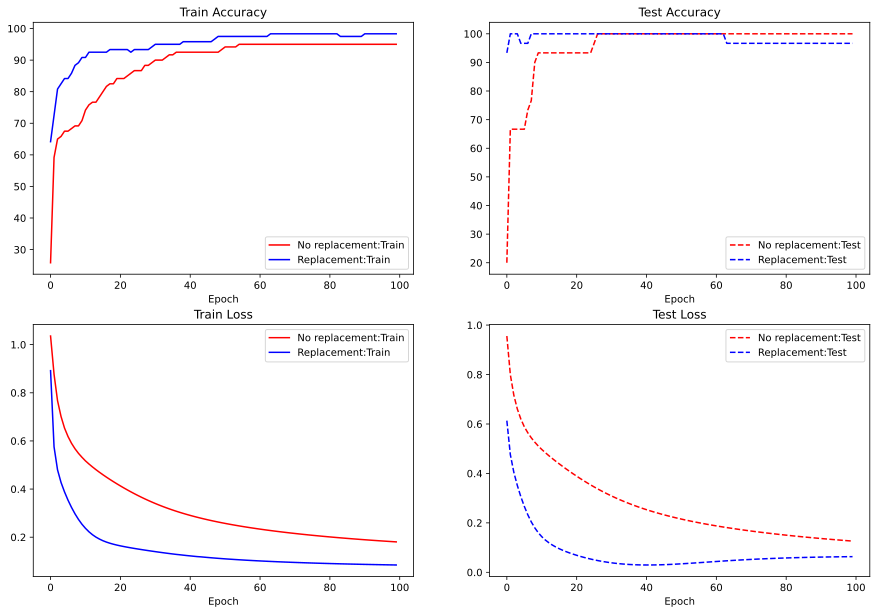

In [64]:
# Plot results
fig, ax = plt.subplots(2, 2, figsize=(15, 10)) 

ax[0][0].plot(training_results_nore['metrics']['train_accuracy'],'r',label='No replacement:Train')
ax[0][0].plot(training_results_re['metrics']['train_accuracy'], 'b',label='Replacement:Train')
ax[0][0].set_title('Train Accuracy')

ax[0][1].plot(training_results_nore['metrics']['test_accuracy'],'r--',label='No replacement:Test')
ax[0][1].plot(training_results_re['metrics']['test_accuracy'],'b--',label='Replacement:Test')
ax[0][1].set_title('Test Accuracy')

ax[1][0].plot(training_results_nore['metrics']['train_loss'],'r',label='No replacement:Train')
ax[1][0].plot(training_results_re['metrics']['train_loss'], 'b',label='Replacement:Train')
ax[1][0].set_title('Train Loss')

ax[1][1].plot(training_results_nore['metrics']['test_loss'],'r--',label='No replacement:Test')
ax[1][1].plot(training_results_re['metrics']['test_loss'],'b--',label='Replacement:Test')
ax[1][1].set_title('Test Loss')

for row in ax:
    for col in row:
        col.set_xlabel('Epoch')
        col.legend()

plt.show()

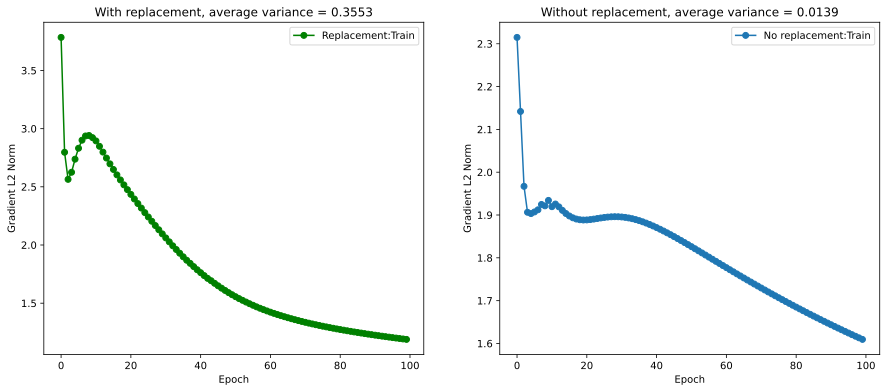

In [65]:
# Gradient Norm Plots
fig,ax = plt.subplots(1,2,figsize=(15,6))

# Get average variance with replacement
var_re = round(np.mean(training_results_re['metrics']['gradient_variance']).item(),4)
# Get average variance without replacement
var_nore = round(np.mean(training_results_nore['metrics']['gradient_variance']).item(),4)

# Sampling with replacement
ax[0].plot(training_results_re['metrics']['gradient_norms'], 'g',marker='o',label='Replacement:Train')
ax[0].set_title(f'With replacement, average variance = {var_re}')

# Sampling without replacement
ax[1].plot(training_results_nore['metrics']['gradient_norms'],marker='o',label='No replacement:Train')
ax[1].set_title(f'Without replacement, average variance = {var_nore}')

# Set common labels
for i in range(2):
    ax[i].set_xlabel('Epoch')
    ax[i].set_ylabel('Gradient L2 Norm')
    ax[i].legend()


plt.show()

### Real Experiments(30 runs)

In [96]:
# Set seed for reproducibility of data split
GLOBAL_SEED = 42
torch.manual_seed(GLOBAL_SEED)
np.random.seed(GLOBAL_SEED)
random.seed(GLOBAL_SEED)

In [97]:
# Split data
train_loader_base, test_loader_base = split_data(data, labels, replacement=False)

In [98]:
num_runs = NUM_SAMPLE

In [99]:
# Initialize the stats tracker
metrics_tracker = MetricsTracker()

# Run the experiments(5 runs)
for scheme, replacement_flag in SAMPLING_SCHEMES.items(): 
    for run in range(num_runs):

        # Each run: new model, but deterministic init for fair comparison
        torch.manual_seed(GLOBAL_SEED + run)
        np.random.seed(GLOBAL_SEED + run)
        random.seed(GLOBAL_SEED + run)

        # Build a multi-layer neural net
        model, loss_function, learning_rate, optimizer = create_model()

        # Create appropriate data loader using base indices but with replacement toggle
        train_loader, _ = split_data(data, labels, replacement=replacement_flag)

        # Train model and retrieve results 
        training_results = train_model(model,loss_function,optimizer,learning_rate,train_loader,test_loader_base, epochs=100)

        # Calculate the final averaged metrics for this run
        tracked_metrics = {
            'train_acc': round(np.mean(training_results['metrics']['train_accuracy']).item(),4),
            'test_acc': round(np.mean(training_results['metrics']['test_accuracy']).item(),4),
            'train_loss': round(np.mean(training_results['metrics']['train_loss']).item(),4),
            'test_loss': round(np.mean(training_results['metrics']['test_loss']).item(),4)
        }

        # Store stats metrics using the class method
        metrics_tracker.add_run_results(scheme, tracked_metrics)
    

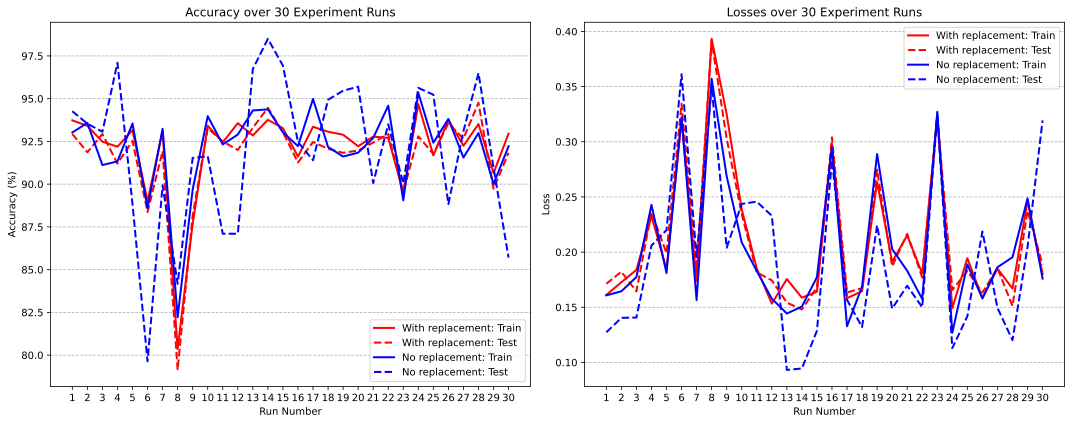

In [100]:
# Plot results
plot_scheme_comparison(metrics_tracker, num_runs)

### Get confidence intervals results

In [101]:
results = metrics_tracker.get_all_CIs()

print("--- Confidence Interval Results (95%) ---")
for scheme, metrics_ci in results.items():
    print(f"\nScheme: {scheme}")
    for metric, bounds in metrics_ci.items():
        if bounds[0] is not None:
            print(f"  {metric:<10}: CI = ({bounds[0]:.4f}, {bounds[1]:.4f})")
        else:
            print(f"  {metric:<10}: CI = (No data)")

--- Confidence Interval Results (95%) ---

Scheme: With replacement
  train_acc : CI = (91.0702, 93.0692)
  test_acc  : CI = (90.5967, 92.6877)
  train_loss: CI = (0.1862, 0.2336)
  test_loss : CI = (0.1869, 0.2341)

Scheme: No replacement
  train_acc : CI = (91.2239, 93.0967)
  test_acc  : CI = (90.3735, 93.5999)
  train_loss: CI = (0.1799, 0.2261)
  test_loss : CI = (0.1667, 0.2227)
